In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import tensorflow as tf
#from talos.model.layers import hidden_layers
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, LocallyConnected1D, Conv1D, Reshape
from keras.callbacks import ModelCheckpoint, History
from keras.activations import relu, elu, linear
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score as R2
from sklearn.model_selection import cross_val_score, KFold, train_test_split

from tqdm import trange

plt.style.use('seaborn-darkgrid')
mpl.rcParams['figure.figsize'] = [10.0, 4.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 12

In [28]:
def accuracy_score(Y_test, Y_pred):
    return np.sum(Y_test == Y_pred) / len(Y_test)

In [29]:
data_pd = pd.read_pickle("../data/credit_card_cleaned.pickle")
data = data_pd.to_numpy(); data_pd.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,19320.000000,19320.000000,19320.000000,19320.000000,19320.000000,19320.000000,19320.000000,19320.000000,19320.000000,19320.000000,...,19320.000000,19320.000000,19320.000000,19320.000000,19320.000000,19320.000000,19320.000000,19320.000000,19320.000000,19320.000000
mean,123326.708075,1.604762,1.906470,1.558489,35.186439,0.098913,-0.034679,-0.076863,-0.154658,-0.217754,...,24693.602743,22678.421377,21713.804658,2103.018064,1991.167340,1681.339027,1459.691304,1466.604451,1429.969410,0.260352
std,97095.352732,0.488914,0.769925,0.524265,9.512988,1.156387,1.268066,1.282033,1.271065,1.238789,...,28906.454304,27418.070773,27136.892101,2027.576588,1987.052215,1838.526021,1658.875003,1683.291814,1696.001956,0.438838
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-15588.000000,-20254.000000,-24920.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,27.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,1000.000000,737.000000,445.500000,355.000000,300.000000,6.000000,0.000000,0.000000,0.000000,0.000000
50%,90000.000000,2.000000,2.000000,2.000000,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,15299.500000,13142.000000,10752.000000,1737.500000,1600.000000,1214.500000,1000.000000,1000.000000,1000.000000,0.000000
75%,180000.000000,2.000000,2.000000,2.000000,41.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,38324.000000,32418.250000,30549.500000,3000.000000,3000.000000,2428.250000,2052.000000,2062.000000,2004.000000,1.000000
max,420000.000000,2.000000,6.000000,3.000000,75.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,132677.000000,122506.000000,120940.000000,11009.000000,11242.000000,10661.000000,9567.000000,9652.000000,9817.000000,1.000000


In [30]:
input_data = data[:,1:-1]
output_data = data[:,-1]
nr_params = input_data.shape[1]; nr_params

22

In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(input_data, output_data)
Scaler = preprocessing.StandardScaler()
X_train_scaled = Scaler.fit_transform(X_train)
X_test_scaled = Scaler.transform(X_test)

In [62]:
opti = optimizers.Adam(amsgrad=True)
def nn_reg():
    model = Sequential()
    model.add(Dense(16, input_shape=(nr_params,), activation="relu", kernel_initializer='random_uniform'))
    model.add(Dense(8, activation="relu", kernel_initializer='random_uniform'))
    model.add(Dense(1, activation="sigmoid", kernel_initializer='random_uniform'))
    model.compile(optimizer=opti, loss="binary_crossentropy",  metrics=["accuracy"])
    return model
nn_reg().summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 16)                368       
_________________________________________________________________
dense_46 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 9         
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


In [63]:
clf = KerasClassifier(build_fn=nn_reg, batch_size=2, epochs=20, validation_split=0.2, verbose=0)
history = clf.fit(X_train_scaled, Y_train)

In [64]:
Y_pred = clf.predict(X_test_scaled)
Y_pred = np.where(Y_pred > 0.5, 1, 0)

In [65]:
accuracy_score(Y_pred.T[0], Y_test)

0.7865424430641822

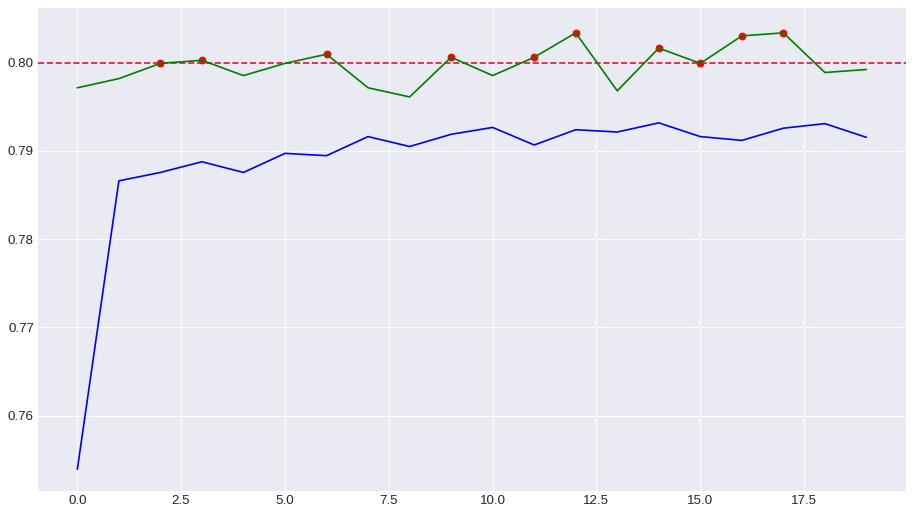

In [66]:
plt.figure(figsize=(14,8))
acc = np.array(history.history["accuracy"])
val_acc = np.array(history.history["val_accuracy"])
asdf = np.argsort(val_acc)[-10:]
plt.axhline(y=val_acc[asdf[0]], c="crimson", ls="--")
plt.plot(acc, c="b")
plt.plot(val_acc, c="g")
plt.scatter(asdf, val_acc[asdf], c="r")